# Detecting Retina Damage From Optical Coherence Tomography (OCT) Images, using Transfer Learning on VGG16 CNN Model
## Context
Retinal Optical Coherence Tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

![Figure 1.](https://i.imgur.com/fSTeZMd.png)

Figure 1. Representative Optical Coherence Tomography Images and the Workflow Diagram \[Kermany et. al. 2018\]

(A) (Far left) Choroidal Neo-Vascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic Macular Edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

## Content
* The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL,CNV,DME,DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN).
* Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

* Optical coherence tomography (OCT) images (Spectralis OCT, Heidelberg Engineering, Germany) were selected from retrospective cohorts of adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017.

## Acknowledgements
* Data: https://data.mendeley.com/datasets/rscbjbr9sj/2
* Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG

import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [3]:
pwd

'C:\\Users\\onral\\Desktop\\techpro python and others\\deep learning\\capstone project 2'

In [3]:
data_dir = "C:\\Users\\onral\\Desktop\\techpro python and others\\deep learning\\capstone project 2\\OCT2017"
train_data_dir= 'C:\\Users\\onral\\Desktop\\techpro python and others\\deep learning\\capstone project 2\\OCT2017\\train'
test_data_dir= 'C:\\Users\\onral\\Desktop\\techpro python and others\\deep learning\\capstone project 2\\OCT2017\\test'

img_width, img_height = 150, 150 
channels = 3 #its  mean rgb
batch_size = 32


In [5]:
os.listdir(data_dir)

['test', 'train']

In [6]:
train_path = data_dir+'\\train'
test_path = data_dir+'\\test'

In [7]:
os.listdir(train_path)

['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [8]:
len(os.listdir(train_path+'/DME'))

11348

In [9]:
len(os.listdir(train_path+'/DRUSEN'))

8616

In [10]:
len(os.listdir(train_path+'/NORMAL'))

26315

In [11]:
len(os.listdir(train_path+'/CNV'))

37205

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions

Counts for each category:
CNV: 37205
DME: 11348
DRUSEN: 8616
NORMAL: 26315


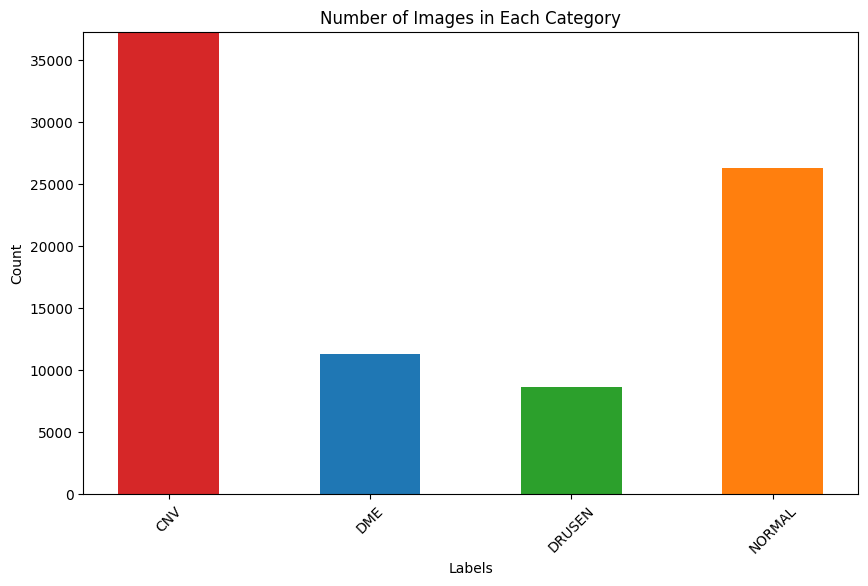

In [6]:
import matplotlib.pyplot as plt
from glob import glob
import os

# Assuming train_data_dir is defined

# Count the number of images in each category
cnv_images = len(glob(os.path.join(train_data_dir, 'CNV', '*.jpeg')))
dme_images = len(glob(os.path.join(train_data_dir, 'DME', '*.jpeg')))
drusen_images = len(glob(os.path.join(train_data_dir, 'DRUSEN', '*.jpeg')))
normal_images = len(glob(os.path.join(train_data_dir, 'NORMAL', '*.jpeg')))

# Prepare data for plotting
data = {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys())
count = list(data.values())

# Print counts for each category
print("Counts for each category:")
for label, c in zip(labels, count):
    print(f"{label}: {c}")

# Set figure size and create subplot
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

# Plot the bar chart with adjusted width and colors
ax.bar(labels, count, color=['tab:red', 'tab:blue', 'tab:green', 'tab:orange'], width=0.5)

# Set labels and title
ax.set_xlabel("Labels")
ax.set_ylabel("Count")
ax.set_title("Number of Images in Each Category")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust y-axis limits
ax.set_ylim(0, max(count) + 50)  # Increase 50 for better visibility

# Save the plot
plt.savefig('labels_vs_counts.png', transparent=False, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()


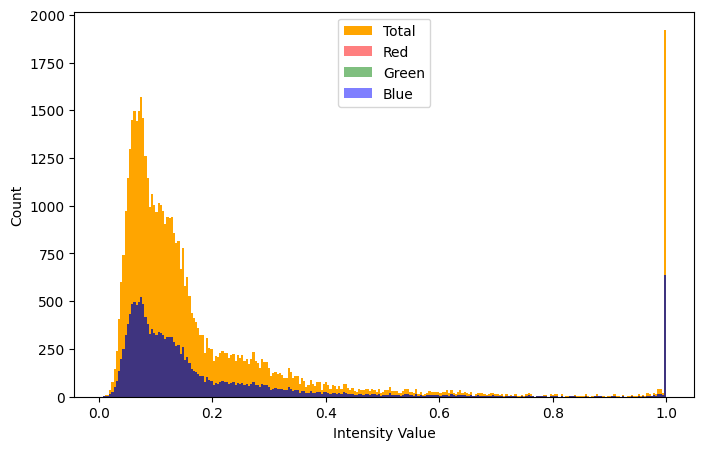

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.color import gray2rgb

# Define the image path
image_path = r'C:\Users\onral\Desktop\techpro python and others\deep learning\capstone project 2\OCT2017\train\NORMAL\NORMAL-1001666-1.jpeg'

# Read the image
image = mpimg.imread(image_path)

# Resize the image to 128x128 and convert to RGB
color_img = gray2rgb(resize(image, (128, 128)))

# Set figure size
plt.rcParams['figure.figsize'] = (8.0, 5.0)

# Plot histograms for each channel
plt.hist(color_img.ravel(), bins=256, color='orange')
plt.hist(color_img[:, :, 0].ravel(), bins=256, color='red', alpha=0.5)
plt.hist(color_img[:, :, 1].ravel(), bins=256, color='green', alpha=0.5)
plt.hist(color_img[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5)

# Set labels and legend
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Total', 'Red', 'Green', 'Blue'])

# Save the histogram plot
plt.savefig('histogram.png', transparent=False, bbox_inches='tight', dpi=400)

# Show the histogram plot
plt.show()


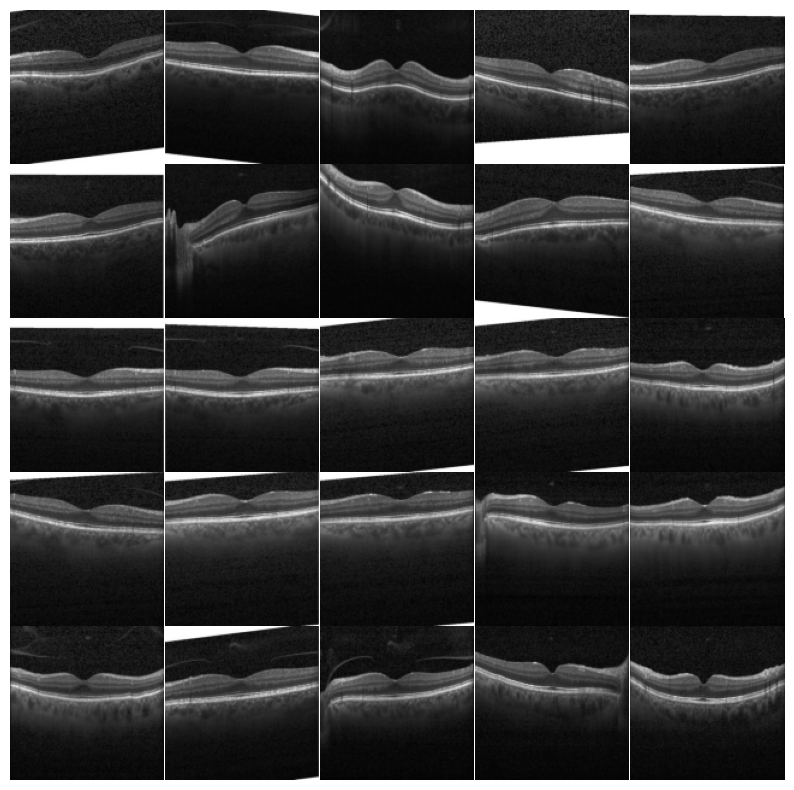

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.color import gray2rgb
from glob import glob

# Set the directory containing the images
data_dir = 'C:\\Users\\onral\\Desktop\\techpro python and others\\deep learning\\capstone project 2\\OCT2017'

# Get file paths of the normal eye images
normal_images = glob(data_dir + '\\train\\NORMAL\\**')

# Limit the number of images to display to 25
num_images_to_display = min(len(normal_images), 25)

# Set the figure size and adjust subplot spacing
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)

# Loop over the first 25 images
for i in range(num_images_to_display):
    # Read the image
    image = mpimg.imread(normal_images[i])
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    # Convert grayscale image to RGB
    image_resized_rgb = gray2rgb(image_resized)
    # Plot the image
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized_rgb)
    plt.axis('off')

# Show the plotted images
plt.show()


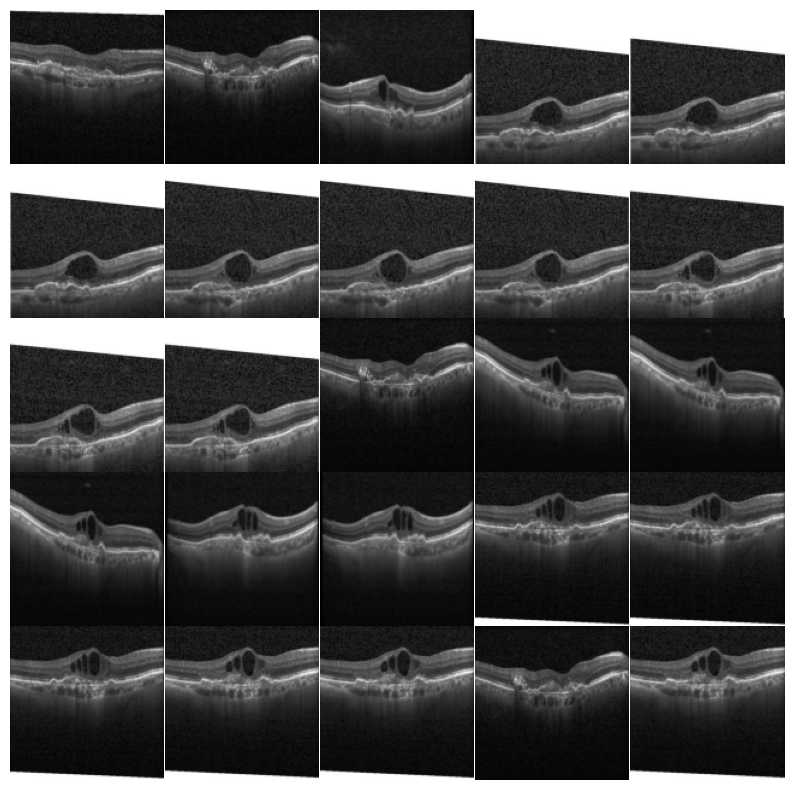

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.color import gray2rgb
from glob import glob

# Set the directory containing the images
data_dir = 'C:\\Users\\onral\\Desktop\\techpro python and others\\deep learning\\capstone project 2\\OCT2017'

# Get file paths of the normal eye images
normal_images = glob(data_dir + '\\train\\CNV\\**')

# Limit the number of images to display to 25
num_images_to_display = min(len(normal_images), 25)

# Set the figure size and adjust subplot spacing
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)

# Loop over the first 25 images
for i in range(num_images_to_display):
    # Read the image
    image = mpimg.imread(normal_images[i])
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    # Convert grayscale image to RGB
    image_resized_rgb = gray2rgb(image_resized)
    # Plot the image
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized_rgb)
    plt.axis('off')

# Show the plotted images
plt.show()


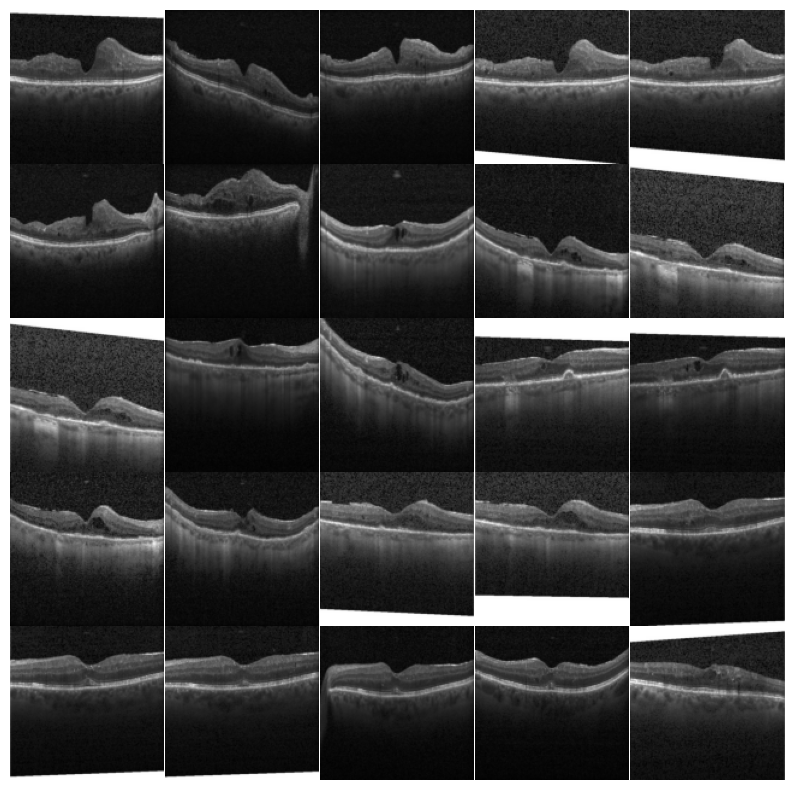

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.color import gray2rgb
from glob import glob

# Set the directory containing the images
data_dir = 'C:\\Users\\onral\\Desktop\\techpro python and others\\deep learning\\capstone project 2\\OCT2017'

# Get file paths of the normal eye images
normal_images = glob(data_dir + '\\train\\DME\\**')

# Limit the number of images to display to 25
num_images_to_display = min(len(normal_images), 25)

# Set the figure size and adjust subplot spacing
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)

# Loop over the first 25 images
for i in range(num_images_to_display):
    # Read the image
    image = mpimg.imread(normal_images[i])
    # Resize the image to 128x128
    image_resized = resize(image, (128, 128))
    # Convert grayscale image to RGB
    image_resized_rgb = gray2rgb(image_resized)
    # Plot the image
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_resized_rgb)
    plt.axis('off')

# Show the plotted images
plt.show()


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=(0.73, 0.9),
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    fill_mode='constant',
    height_shift_range=0.1,   
    brightness_range=(0.55, 0.9)
)

# Validation and test data preprocessing
valid_test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [17]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83484 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [18]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)


nb_train_samples = len(train_generator.filenames)  
nb_test_samples = len(test_generator.filenames)


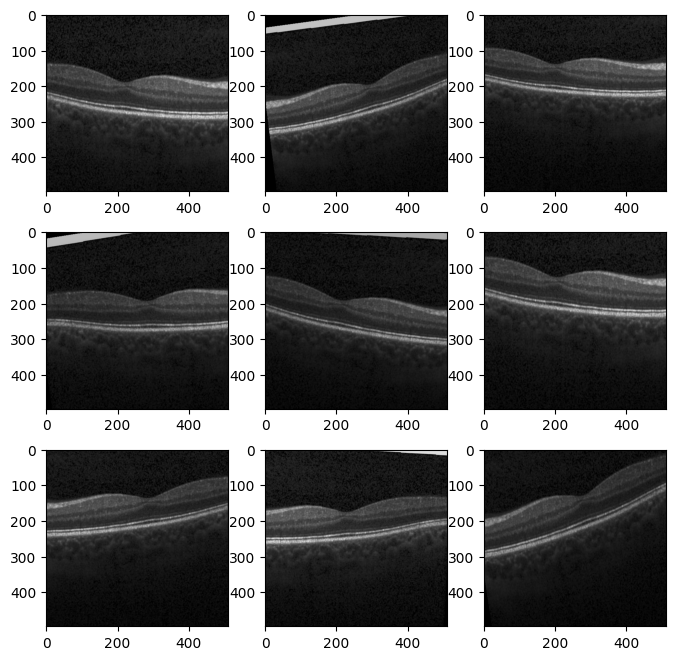

In [19]:
img = load_img(r'C:\Users\onral\Desktop\techpro python and others\deep learning\capstone project 2\OCT2017\train\NORMAL\NORMAL-1001772-4.jpeg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)
plt.rcParams['figure.figsize'] = (8.0, 8.0)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16

# Define the input shape
input_shape = (img_width, img_height, channels)

# Load pre-trained VGG16 model
vgg16 = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

# Create a Sequential model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 70, 70, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 68, 68, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.applications import VGG16

# Initialize a Sequential model
model = Sequential()

# Add layers from the pre-trained VGG16 model
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, channels))
for layer in vgg16.layers:
    model.add(layer)

# Set the pre-trained layers to non-trainable
for layer in model.layers:
    layer.trainable = False

# Add layers for classification on top of the VGG16 layers
model.add(Flatten(input_shape=(4, 4, 512)))  # Flatten layer to convert 4x4x512 feature maps to a 1D vector
model.add(Dropout(0.2))  # Dropout layer for regularization to prevent overfitting
model.add(Dense(4, activation='softmax'))  # Dense layer for classification with softmax activation

# Display the summary of the model architecture
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)      

In [22]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    save_freq='epoch'  # Adjusted argument
)


earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [24]:
# bu kodun calismasi cok uzun suruyor

history = model.fit(
    train_generator,  # Training data generator
    epochs=10,  # Number of epochs
    steps_per_epoch=nb_train_samples // batch_size,  # Number of steps per epoch
    verbose=2,  # Verbosity mode (0: silent, 1: progress bar, 2: one line per epoch)
    callbacks=callbacks,  # List of callbacks to apply during training
    shuffle=True  # Shuffle training data before each epoch
)

Epoch 1/10



2608/2608 - 1636s - loss: 0.5191 - accuracy: 0.8101 - lr: 0.0010 - 1636s/epoch - 627ms/step
Epoch 2/10


2608/2608 - 1546s - loss: 0.4553 - accuracy: 0.8354 - lr: 0.0010 - 1546s/epoch - 593ms/step
Epoch 3/10


2608/2608 - 1525s - loss: 0.4449 - accuracy: 0.8402 - lr: 0.0010 - 1525s/epoch - 585ms/step
Epoch 4/10


2608/2608 - 1530s - loss: 0.4449 - accuracy: 0.8413 - lr: 0.0010 - 1530s/epoch - 587ms/step
Epoch 5/10


2608/2608 - 1532s - loss: 0.4392 - accuracy: 0.8439 - lr: 0.0010 - 1532s/epoch - 587ms/step
Epoch 6/10


2608/2608 - 1526s - loss: 0.4404 - accuracy: 0.8433 - lr: 0.0010 - 1526s/epoch - 585ms/step
Epoch 7/10


2608/2608 - 1529s - loss: 0.4425 - accuracy: 0.8446 - lr: 0.0010 - 1529s/epoch - 586ms/step
Epoch 8/10


2608/2608 - 1532s - loss: 0.4428 - accuracy: 0.8427 - lr: 0.0010 - 1532s/epoch - 588ms/step
Epoch 9/10


2608/2608 - 1535s - loss: 0.4428 - accuracy: 0.8424 - lr: 0.0010 - 1535s/epoch - 589ms/step
Epoch 10/10


2608/2608 - 1542s - loss: 0.4358 - accuracy: 0.8464 - lr: 0.0010 - 1542s/epoch - 591ms/step


In [25]:
(ev_loss, ev_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', ev_loss)
print('Test Accuracy: ', ev_accuracy)

32/32 [==============================] - 25s 765ms/step - loss: 0.3337 - accuracy: 0.8650
Test Loss:  0.33370333909988403
Test Accuracy:  0.8650000095367432


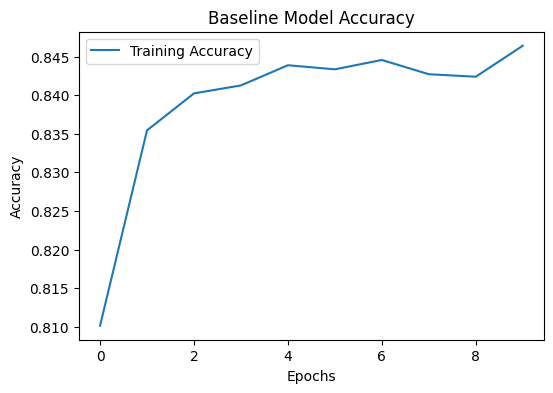

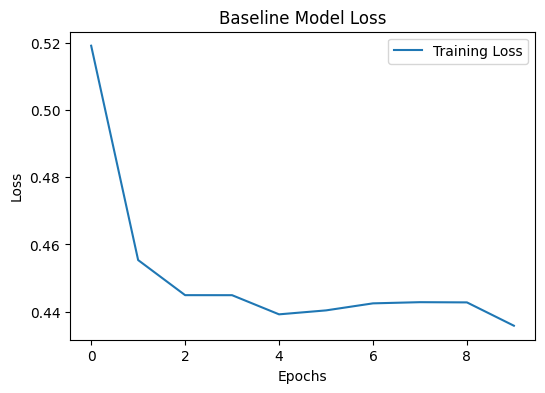

In [27]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent=False, bbox_inches='tight', dpi=400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss'])
plt.savefig('baseline_loss_epoch.png', transparent=False, bbox_inches='tight', dpi=400)
plt.show()



In [ ]:
model.trainable= True
model.compile(optimizer= keras.optimizers.Adam(1e-5), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [28]:
import tensorflow.keras as keras

# Enable training of all layers in the model
model.trainable = True

# Compile the model with a specific optimizer, loss function, and metrics
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
loss_function = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)


In [29]:
checkpoint = ModelCheckpoint(
    'finetuned_model.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    save_freq='epoch'  # Adjusted argument
)


earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "finetuned_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]


In [33]:

history_1 = model.fit(
    train_generator,                  # Generator providing batches of training data
    epochs=3,                        # Number of epochs to train the model
    steps_per_epoch=nb_train_samples // batch_size,  # Number of steps (batches) to consider as one epoch
    verbose=2,                        # Verbosity mode: 0=silent, 1=progress bar, 2=one line per epoch
    callbacks=callbacks,              # List of callbacks to apply during training
    shuffle=True                      # Whether to shuffle the training data at the beginning of each epoch
)


Epoch 1/10

Epoch 1: loss improved from inf to 0.18969, saving model to finetuned_model.h5
2608/2608 - 6559s - loss: 0.1897 - accuracy: 0.9360 - lr: 1.0000e-05 - 6559s/epoch - 3s/step
Epoch 2/10

Epoch 2: loss improved from 0.18969 to 0.16042, saving model to finetuned_model.h5
2608/2608 - 6429s - loss: 0.1604 - accuracy: 0.9465 - lr: 1.0000e-05 - 6429s/epoch - 2s/step
Epoch 3/10

Epoch 3: loss improved from 0.16042 to 0.14443, saving model to finetuned_model.h5
2608/2608 - 6379s - loss: 0.1444 - accuracy: 0.9516 - lr: 1.0000e-05 - 6379s/epoch - 2s/step
Epoch 4/10


KeyboardInterrupt: 

In [ ]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Finetuned Model Accuracy')
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Finetuned Model Loss')
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

In [ ]:

(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

In [ ]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)

# Compute classification report
target_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(test_generator.classes, y_pred, target_names=target_names)
print('Classification Report:\n', classification_rep)
